In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

  Preparing metadata (setup.py) ... done
  Created wheel for tf-nightly-gpu-2.0-preview: filename=tf_nightly_gpu_2_0_preview-0.0.0.1-py3-none-any.whl size=1542 sha256=79f77ad0b1bb0a826bda42120a7db195f076243532379ac4bc5ca056af02133f
  Stored in directory: /root/.cache/pip/wheels/89/c6/2e/5b35865ca6234c39a564b7803e8105a8050cb66121a475b27c
Successfully built tf-nightly-gpu-2.0-preview


In [2]:
device_name=tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **EfficientNetV2L model**

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# Ensure TensorFlow is using GPU

if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available and being used.")
else:
    print("❌ No GPU found. Check Kaggle settings.")

✅ GPU is available and being used.


Class Distribution Before Oversampling:
DRUSEN: 8616 images
CNV: 37205 images
NORMAL: 51140 images
DME: 11348 images


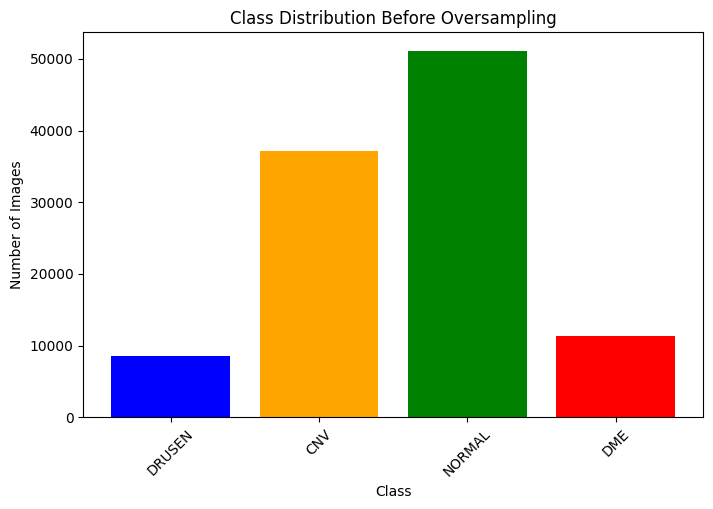

In [5]:
# -------------------------------
# Count Images in Each Class (Before Training)
# -------------------------------
import os 

def count_images_in_classes(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):  
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

dataset_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train"
class_counts_before = count_images_in_classes(dataset_path)

print("Class Distribution Before Oversampling:")
for class_name, count in class_counts_before.items():
    print(f"{class_name}: {count} images")

# Plot class distribution before oversampling
plt.figure(figsize=(8, 5))
plt.bar(class_counts_before.keys(), class_counts_before.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)
plt.show()

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load the training set (76,000 images)
training_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Use the original dataset folder
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # The remaining images will go to validation
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Load the validation set (remaining images)
validation_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/train",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42,
    validation_split=1 - (76000 / 108309),  # Same split ratio
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Train dataset size:", training_set.cardinality().numpy() * 32)
print("Validation dataset size:", validation_set.cardinality().numpy() * 32)


Found 108309 files belonging to 4 classes.
Using 76000 files for training.
Found 108309 files belonging to 4 classes.
Using 32309 files for validation.
Train dataset size: 76000
Validation dataset size: 32320


In [7]:
INPUT_SHAPE=(224, 224,3)

In [8]:
effnet = tf.keras.applications.EfficientNetV2B0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=INPUT_SHAPE,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    include_preprocessing=True
)

29403144/29403144 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
model = tf.keras.models.Sequential()

In [10]:
model.add(tf.keras.Input(shape=INPUT_SHAPE))

In [11]:
model.add(effnet)

In [12]:
model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

In [13]:
metrics_list=["accuracy", tf.keras.metrics.F1Score()]

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=metrics_list)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 1000)                │       7,200,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           4,004 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,204,316 (27.48 MB)

 Trainable params: 7,143,708 (27.25 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [16]:
training_history=model.fit(x=training_set, validation_data=validation_set, epochs=15)

Epoch 1/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 409s 138ms/step - accuracy: 0.8364 - f1_score: 0.6209 - loss: 1.2175 - val_accuracy: 0.9482 - val_f1_score: 0.9025 - val_loss: 0.9260
Epoch 2/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 306s 129ms/step - accuracy: 0.9454 - f1_score: 0.9031 - loss: 0.8654 - val_accuracy: 0.9551 - val_f1_score: 0.9211 - val_loss: 0.6838
Epoch 3/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.9593 - f1_score: 0.9295 - loss: 0.6418 - val_accuracy: 0.9595 - val_f1_score: 0.9297 - val_loss: 0.5191
Epoch 4/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 305s 128ms/step - accuracy: 0.9654 - f1_score: 0.9401 - loss: 0.4878 - val_accuracy: 0.9655 - val_f1_score: 0.9395 - val_loss: 0.3980
Epoch 5/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 306s 129ms/step - accuracy: 0.9708 - f1_score: 0.9495 - loss: 0.3737 - val_accuracy: 0.9721 - val_f1_score: 0.9506 - val_loss: 0.3045
Epoch 6/15
2375/2375 ━━━━━━━━━━━━━━━━━━━━ 305s 129ms/step - accuracy: 0.9755 - f1_score: 0.9574 - loss: 0.2861 - val_acc

In [17]:
model.save("efficientNet_model.h5")
model.save("efficientNet_model.keras")

In [18]:
import pickle

# Save the training history (history.history is a dict with loss/accuracy values per epoch)
with open("efficientNet_Training_history.pkl", "wb") as file:
    pickle.dump(training_history.history, file)

# **Model performance**

In [19]:
#REloading history from pickle file
import pickle
with open("efficientNet_Training_history.pkl", "rb") as f:
    load_history=pickle.load(f)
print(load_history)

{'accuracy': [0.8888289332389832, 0.9490000009536743, 0.9603947401046753, 0.9661710262298584, 0.9714605212211609, 0.9758947491645813, 0.9800131320953369, 0.9828420877456665, 0.9848684072494507, 0.9865657687187195, 0.9877631664276123, 0.9889868497848511, 0.9904342293739319, 0.9911184310913086, 0.9914736747741699], 'f1_score': [<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9026399 , 0.82637537, 0.2947706 , 0.9512241 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9543197 , 0.92019665, 0.7874428 , 0.9779489 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9655066 , 0.94023997, 0.8346838 , 0.98216367], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9702601 , 0.95479375, 0.85328084, 0.9849801 ], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9750725 , 0.9605761 , 0.8768175 , 0.98746157], dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.97874135, 0.9680897 , 0.8942

In [20]:
load_history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss'])

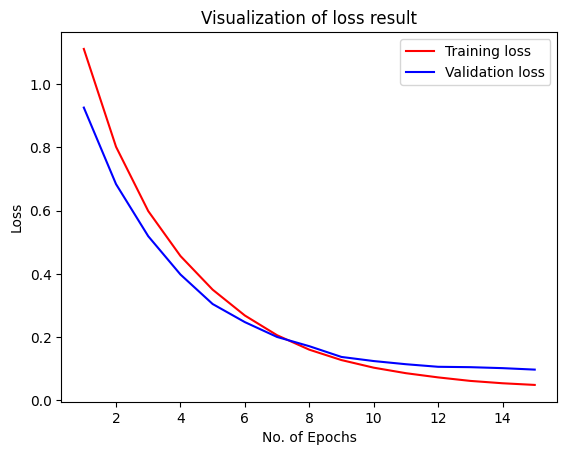

In [21]:
#Loss visualization
epochs=[i for i in range(1, 16)]
plt.plot(epochs, load_history['loss'], color='red', label='Training loss')
plt.plot(epochs, load_history['val_loss'], color='Blue', label='Validation loss')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of loss result")
plt.legend()
plt.show()

# **Model Evaluation**

In [22]:
#pre-processing the test dataset
test_set = image_dataset_from_directory(
    "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test",  # Same dataset directory
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1000 files belonging to 4 classes.


In [23]:
test_loss, test_acc, f1_score=model.evaluate(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9742 - f1_score: 0.6373 - loss: 0.1060


In [24]:
test_loss, test_acc, f1_score

(0.14094793796539307,
 0.9649999737739563,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.9389313, 0.9900199, 0.9369747, 0.9939879], dtype=float32)>)

In [25]:
true_categories=tf.concat([y for x, y in test_set], axis=0)
Y_true=tf.argmax(true_categories, axis=1)

In [26]:
#computing predicted labels using test_set
predicted_categories = model.predict(test_set)

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step


In [27]:
Y_Pred=tf.argmax(predicted_categories, axis=1)
Y_Pred

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
    

# **Classification Report**

In [28]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_Pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       250
           1       0.99      0.99      0.99       250
           2       0.99      0.89      0.94       250
           3       1.00      0.99      0.99       250

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000



# **Confusion Matrix**

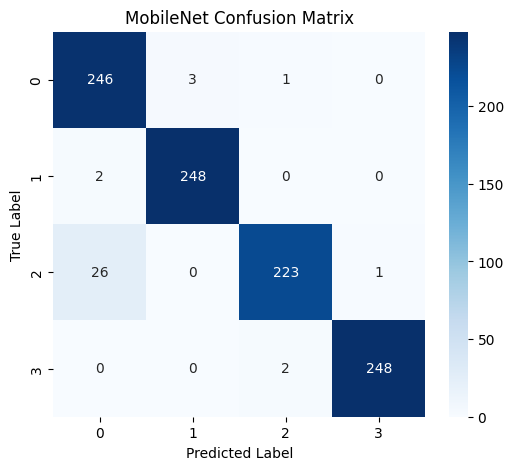

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm=confusion_matrix(Y_true, Y_Pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MobileNet Confusion Matrix", fontsize=12)
plt.show()

# **Single Prediction Code**

In [30]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import numpy as np
import os

In [ ]:
model = tf.keras.models.load_model("MobileNet_model.h5")

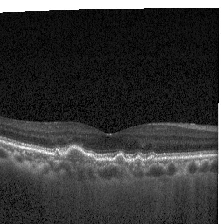

In [31]:
image_path = "/kaggle/input/eye-disease-detection/Project Exhibition 2 Dataset/test/DRUSEN/DRUSEN-11129-2.jpeg"
img = tf.keras.utils.load_img(image_path, target_size=(224,224))
img

In [32]:
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [33]:
x.shape

(1, 224, 224, 3)

In [34]:
pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [35]:
class_name=['CNV', 'DME', 'DRUSEN', 'NORMAL']
result_index = np.argmax(pred)
print("Model Prediction: ", class_name[result_index])

Model Prediction:  DRUSEN
